### Import Library

In [44]:
# Import library yang diperlukan
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam


#ignore warning
import warnings
warnings.filterwarnings('ignore')

### Direktori

In [45]:
K1 = 'D:/UTY/Semester 7/Pengembangan Aplikasi AI/Pengenal-Citra-Nomor-Kendaraan/Dataset/K1/'
K2 = 'D:/UTY/Semester 7/Pengembangan Aplikasi AI/Pengenal-Citra-Nomor-Kendaraan/Dataset/K2/'
K3 = 'D:/UTY/Semester 7/Pengembangan Aplikasi AI/Pengenal-Citra-Nomor-Kendaraan/Dataset/K3/'
K4 = 'D:/UTY/Semester 7/Pengembangan Aplikasi AI/Pengenal-Citra-Nomor-Kendaraan/Dataset/K4/'

In [46]:
imagePaths = 'Dataset\\'
label_list = ['K1']
data = []
labels = []

### Preprocessing

In [47]:
for label in label_list:
    for imagePath in glob.glob(imagePaths+label+'\\*.JPG'):
        #print(imagePath)
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (32, 32))
        data.append(image)
        labels.append(label)

In [48]:
np.array(data).shape

(237, 32, 32, 3)

In [54]:
# ubah type data dari list menjadi array
# ubah nilai dari tiap pixel menjadi range [0..1]
data = np.array(data, dtype='float') / 255.0
labels = np.array(labels)

In [49]:
print(labels)

['K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1', 'K1

In [50]:
# ubah nilai dari labels menjadi binary
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Split Data

In [52]:
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42)

In [53]:
print('Ukuran data train =', x_train.shape)
print('Ukuran data test =', x_test.shape)

Ukuran data train = (189, 32, 32, 3)
Ukuran data test = (48, 32, 32, 3)


### Segmentasi Plat Nomor dengan CNN

In [55]:
model = Sequential()
# Extracted Feature Layer
model.add(InputLayer(input_shape=[32, 32, 3]))
model.add(Conv2D(filters=32, kernel_size=2, strides=1,
          padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=50, kernel_size=2, strides=1,
          padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        416       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 50)        6450      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 50)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 8, 8, 50)          0         
                                                                 
 flatten_2 (Flatten)         (None, 3200)             

In [57]:
# tentukan hyperparameter
lr = 0.001
max_epochs = 10
opt_funct = Adam(learning_rate=lr)

In [58]:
# compile arsitektur yang telah dibuat
model.compile(loss='binary_crossentropy',
              optimizer=opt_funct,
              metrics=['accuracy'])

In [59]:
H = model.fit(x_train, y_train, validation_data=(x_test, y_test),
              epochs=max_epochs, batch_size=32)

Epoch 1/10
6/6 [==============================] - 1s 52ms/step - loss: 0.0975 - accuracy: 0.9841 - val_loss: 6.8277e-07 - val_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 0s 29ms/step - loss: 3.4448e-07 - accuracy: 1.0000 - val_loss: 6.1881e-10 - val_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 0s 28ms/step - loss: 2.3238e-10 - accuracy: 1.0000 - val_loss: 8.4228e-12 - val_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 33ms/step - loss: 7.6560e-11 - accuracy: 1.0000 - val_loss: 6.1215e-13 - val_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 0s 31ms/step - loss: 1.0545e-12 - accuracy: 1.0000 - val_loss: 1.2760e-13 - val_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 0s 32ms/step - loss: 8.2871e-13 - accuracy: 1.0000 - val_loss: 5.0800e-14 - val_accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 0s 30ms/step - loss: 2.7574e-13 - accuracy: 1.0000 - val_loss: 2.9811e-1

In [60]:
# menghitung nilai akurasi model terhadap data test
predictions = model.predict(x_test, batch_size=32)
target = (predictions > 0.5).astype(np.int)
print(classification_report(y_test, target, target_names=label_list))

              precision    recall  f1-score   support

          K1       1.00      1.00      1.00        48

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



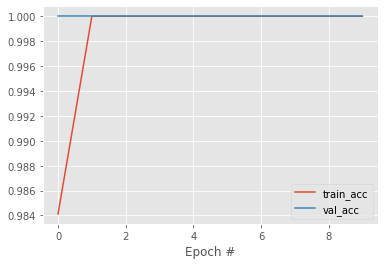

In [61]:
N = np.arange(0, max_epochs)
plt.style.use("ggplot")
plt.figure()
# plt.plot(N, H.history["loss"], label="train_loss")
# plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.legend()
plt.show()

# ---Versi Aqil---

In [5]:
# # Tentukan jalur ke direktori dataset
# dataset_dir = K1

# # Buat daftar semua berkas citra dalam direktori dataset
# berkas_citra = [os.path.join(dataset_dir, berkas) for berkas in os.listdir(dataset_dir) if berkas.endswith('.JPG')]

In [6]:
# # Tetapkan nilai benih acak untuk konsistensi
# random.seed(42)

# # Tentukan rasio data untuk pelatihan dan pengujian
# rasio_pelatihan = 0.8  # 80% untuk pelatihan, 20% untuk pengujian

# # Bagi dataset menjadi set pelatihan dan pengujian
# berkas_pelatihan, berkas_pengujian = train_test_split(berkas_citra, train_size=rasio_pelatihan, test_size=1-rasio_pelatihan)

In [7]:
# # Buat direktori untuk dataset pelatihan dan pengujian jika belum ada
# direktori_pelatihan = os.path.join(dataset_dir, 'pelatihan')
# direktori_pengujian = os.path.join(dataset_dir, 'pengujian')
# os.makedirs(direktori_pelatihan, exist_ok=True)
# os.makedirs(direktori_pengujian, exist_ok=True)

# # Pindahkan berkas ke direktori yang sesuai
# for berkas in berkas_pelatihan:
#     tujuan = os.path.join(direktori_pelatihan, os.path.basename(berkas))
#     os.rename(berkas, tujuan)

# for berkas in berkas_pengujian:
#     tujuan = os.path.join(direktori_pengujian, os.path.basename(berkas))
#     os.rename(berkas, tujuan)

# # Cetak jumlah citra dalam masing-masing dataset
# print(f"Total citra: {len(berkas_citra)}")
# print(f"Citra pelatihan: {len(berkas_pelatihan)}")
# print(f"Citra pengujian: {len(berkas_pengujian)}")

Total citra: 237
Citra pelatihan: 189
Citra pengujian: 48


In [8]:
# Tentukan jalur ke direktori dataset yang telah dibagi menjadi pelatihan dan pengujian
direktori_pengujian = K1+'pengujian/'
direktori_pelatihan = K1+'pelatihan/'

# Tentukan direktori penyimpanan citra yang telah diproses
direktori_pengujian_hasil = K1+'hasil/pengujian/'
direktori_pelatihan_hasil = K1+'hasil/pelatihan/'

In [30]:
def preprocess_citra(berkas_citra):
    # Baca citra dari berkas
    citra = cv2.imread(berkas_citra)
    
    # Pastikan citra tidak None
    if citra is not None:
        # Konversi citra ke skala abu-abu
        citra = cv2.cvtColor(citra, cv2.COLOR_BGR2GRAY)
        
        # Konversi citra menjadi blur
        citra = cv2.GaussianBlur(citra, (5, 5), 0)
        
        # Konversi citra menjadi B & W
        citra = cv2.Canny(citra, 100, 200)
        
        # Mengubah ukuran citra menjadi lebih kecil
        ukuran_citra = (500, 500)
        citra = cv2.resize(citra, ukuran_citra)
        
        # # Normalisasi Data
        # citra = citra / 255.0

    # Kembalikan citra yang telah diproses
    return citra

In [31]:
# Preprocess citra dalam direktori pelatihan
for nama_berkas in os.listdir(direktori_pelatihan):
    berkas_citra = os.path.join(direktori_pelatihan, nama_berkas)
    citra_preprocessed = preprocess_citra(berkas_citra)
    
    # Simpan citra yang telah diproses ke direktori yang sama
    nama_berkas_simpan = os.path.join(direktori_pelatihan_hasil, f'preprocessed_{nama_berkas}')
    cv2.imwrite(nama_berkas_simpan, citra_preprocessed)

In [32]:

# Preprocess citra dalam direktori pengujian
for nama_berkas in os.listdir(direktori_pengujian):
    berkas_citra = os.path.join(direktori_pengujian, nama_berkas)
    citra_preprocessed = preprocess_citra(berkas_citra)
    
    # Simpan citra yang telah diproses ke direktori yang sama
    nama_berkas_simpan = os.path.join(direktori_pengujian_hasil, f'preprocessed_{nama_berkas}')
    cv2.imwrite(nama_berkas_simpan, citra_preprocessed)


# Segmentasi Plat Nomor dengan CNN

In [33]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Fungsi untuk memuat dataset dan anotasinya
def load_dataset(direktori):
    images = []
    labels = []
    
    for nama_berkas in os.listdir(direktori):
        berkas_citra = os.path.join(direktori, nama_berkas)
        citra = cv2.imread(berkas_citra, cv2.IMREAD_GRAYSCALE)
        
        # Normalisasi piksel ke rentang 0-1
        citra = citra / 255.0
        
        images.append(citra)
        
        # Ambil label dari nama berkas (contoh: "plat" atau "non_plat")
        if "plat" in nama_berkas:
            labels.append(1)  # 1 untuk plat
        else:
            labels.append(0)  # 0 untuk non-plat
    
    return np.array(images), np.array(labels)

# Memuat dataset pelatihan dan pengujian
X_train, y_train = load_dataset(direktori_pelatihan_hasil)
X_test, y_test = load_dataset(direktori_pengujian_hasil)

# Membagi dataset pelatihan menjadi pelatihan dan validasi
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Menambahkan dimensi channel untuk input CNN
X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

# Membangun model CNN sederhana
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Kompilasi model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model dengan data pelatihan dan validasi
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluasi model pada data pengujian
hasil_evaluasi = model.evaluate(X_test, y_test)
print(f'Akurasi pada data pengujian: {hasil_evaluasi[1]*100:.2f}%')


Epoch 1/5
5/5 [==============================] - 15s 3s/step - loss: 0.1485 - accuracy: 0.8278 - val_loss: 2.7079e-22 - val_accuracy: 1.0000
Epoch 2/5
5/5 [==============================] - 14s 3s/step - loss: 3.4745e-26 - accuracy: 1.0000 - val_loss: 1.2324e-37 - val_accuracy: 1.0000
Epoch 3/5
5/5 [==============================] - 14s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
5/5 [==============================] - 14s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
2/2 [==============================] - 1s 333ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Akurasi pada data pengujian: 100.00%


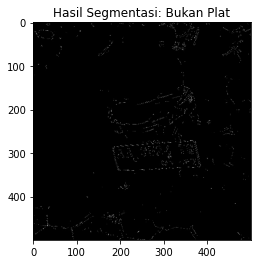

Label Sebenarnya: Bukan Plat


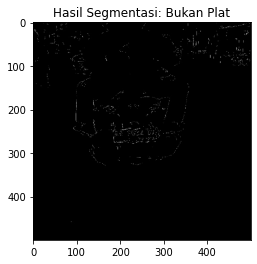

Label Sebenarnya: Bukan Plat


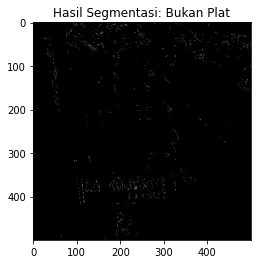

Label Sebenarnya: Bukan Plat


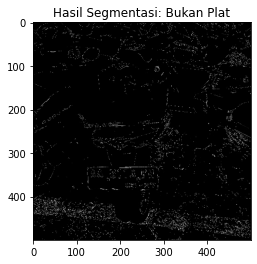

Label Sebenarnya: Bukan Plat


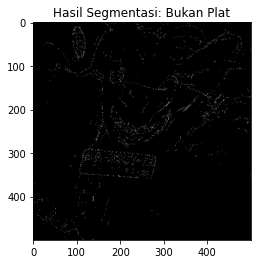

Label Sebenarnya: Bukan Plat


In [34]:
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan hasil segmentasi
def tampilkan_hasil_segmentasi(model, citra):
    # Lakukan prediksi menggunakan model
    prediksi = model.predict(citra.reshape(1, 500, 500, 1))

    # Ambil hasil prediksi (0 atau 1)
    hasil_prediksi = int(prediksi[0][0])

    # Tampilkan citra dan hasil prediksi
    plt.imshow(citra.reshape(500, 500), cmap='gray')
    plt.title(f'Hasil Segmentasi: {"Plat" if hasil_prediksi == 1 else "Bukan Plat"}')
    plt.show()

# Pilih beberapa contoh citra dari dataset pengujian
contoh_citra = X_test[:5]

# Tampilkan hasil segmentasi untuk setiap contoh citra
for i, citra in enumerate(contoh_citra):
    tampilkan_hasil_segmentasi(model, citra)
    print(f'Label Sebenarnya: {"Plat" if y_test[i] == 1 else "Bukan Plat"}')
